# Binary Classification of the "Don't Patronize Me!" Dataset

Perform Binary Classification to predict whether a text contains patronizing and condescending language. The task was task 4 (subtask 1) in the SemEval 2022 competition.

## Initialize Environment

In [2]:
# Library imports
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt    

from nltk import PorterStemmer, WordNetLemmatizer
import codecs

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from tqdm import tqdm
import torch.nn as nn

import re
from functools import partial

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

# Pre-trained models
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel

def fix_seed(seed=420.69):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
#   np.random.seed(seed)
#   random.seed(seed)

fix_seed()

data_path = '../bin/data'
embeddings_path = '../bin/word_embeddings'


/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if not torch.cuda.is_available():
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda:0'

print(DEVICE)

cuda:0


In [4]:
h_params = {
    'model': 'None'
    , 'batch_size': 5
    , 'embedding_dimensions': 50
}

## Raw Data

### Loading

Load the data into pandas dataframes

In [6]:
# Import Data
train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'
test_data_path  = f'{data_path}/task4_test.tsv'

train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])
test_data  = pd.read_csv(test_data_path,  delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text'])

train_data = train_data.drop(['art_id'], axis=1)
test_data = test_data.drop(['art_id'], axis=1)

In [7]:
# Concatenate label information to train data
dev_label_path   = f'{data_path}/dev_semeval_parids-labels.csv'
train_label_path = f'{data_path}/train_semeval_parids-labels.csv'

dev_label   = pd.read_csv(dev_label_path, delimiter=',')
train_label = pd.read_csv(train_label_path, delimiter=',')

detailed_labels = pd.concat([dev_label, train_label], ignore_index=True, join='inner', names=['simple', 'detailed'])
train_data = pd.merge(train_data, detailed_labels, on='par_id')
train_data = train_data.rename(columns={'label_x': 'label', 'label_y': 'label_detailed'})

train_data = train_data.drop('par_id', axis=1)
test_data = test_data.drop('par_id', axis=1)

In [8]:
# Add Binary Classification column for ease of checking
train_data.loc[:, 'is_patronizing'] = 0
train_data.loc[train_data['label'].isin([2,3,4]), 'is_patronizing'] = 1

In [9]:
train_data = train_data.dropna(subset = 'text')
test_data = test_data.dropna(subset = 'text')

In [10]:
keyword_set = sorted(set(train_data['keyword']))
country_set = sorted(set(train_data['country_code']))

def keyword_to_id(country:str, keyword_set=keyword_set):
    return keyword_set.index(country)

def id_to_keyword(id:int, keyword_set=keyword_set):
    assert id >= 0
    assert id < len(keyword_set)
    return keyword_set[id]

def country_to_id(country:str, country_set=country_set):
    return country_set.index(country)

def id_to_country(id:int, country_set=country_set):
    assert id >= 0
    assert id < len(country_set)
    return country_set[id]

## Data Splits

split the data whilst keeping distributions of country, text and is_patronizing counts even

In [30]:
X = train_data[['text', 'keyword', 'country_code']]
y = train_data['is_patronizing']

# The stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. 

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, stratify=train_data[['is_patronizing']])
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape : {X_val.shape}")
print(f"y_test shape : {y_val.shape}")

X_train shape: (8374, 3)
y_train shape: (8374,)
X_test shape : (2094, 3)
y_test shape : (2094,)


In [33]:
# Plotting histogram
y_train.groupby(by='is_patronizing')['is_patronizing'].count().plot(kind='bar')

# Adding labels and title
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Histogram of Label Frequencies')

# Display the plot
plt.show()

KeyError: 'is_patronizing'

## Pre-processing

In [13]:
class LabelledDataset(Dataset):
    def __init__(self, data_frame: pd.DataFrame):
        self.data = data_frame

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Returns a singular item with all pre-processing required for the tester"""

        data = {'keyword'     : self.data['keyword'].iloc[idx],
                'country_code': self.data['country_code'].iloc[idx],
                'text'        : self.data['text'].iloc[idx]}
        
        # instead of label and label_detailed we use is_patronizing
        label = {'is_patronizing': self.data['is_patronizing'].iloc[idx]}

        return data, label
    
class WithheldDataset(Dataset):
    def __init__(self, data_frame: pd.DataFrame):
        self.data = data_frame
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = {'keyword'     : self.data['keyword'].iloc[idx],
                'country_code': self.data['country_code'].iloc[idx],
                'text'        : self.data['text'].iloc[idx]}
        
        return data

In [14]:
# atm, collate_fn is shared between the two functions, therefore, we keep it separate and feed it as input to both functions when we define the DataLoader
def collate_fn(batch, tokenizer, trunc_len = 300):
    """merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style"""

    encodings = []

    # 1. We pad shorter sentences to a length of trunc_len tokens since the maximum sequence size for BERT is 512
    batched_text = [item['text'] for item in batch]
    encodings    = tokenizer(batched_text, return_tensors='pt', padding=True, truncation=True, max_length=trunc_len)

    # 2. We encode the keywords in the sorted order that they appear in the text. We know the set of words from the pre-requisites.
    batched_keywords = list(map(lambda item: keyword_to_id(item['keyword']), batch))
    encodings['keywords'] =  torch.tensor(batched_keywords)

    # 3. We similarly do the above for the countries to get an index encoding of the country
    batched_country_codes = list(map(lambda item: country_to_id(item['country_code']), batch))
    encodings['country_code'] =  torch.tensor(batched_country_codes)

    return encodings

In [15]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# we can check the parameters of this tokenizer
tokenizer

BertTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [26]:
partial_collate = partial(collate_fn, tokenizer=tokenizer)

sampled_train_data = pd.merge(X_train, y_train, left_index=True, right_index=True)
sampled_val_data = pd.merge(X_val, y_val, left_index=True, right_index=True)

test_loader = DataLoader(dataset=WithheldDataset(sampled_train_data), batch_size=h_params['batch_size'], shuffle=True, collate_fn=partial_collate)

val_loader = DataLoader(dataset=WithheldDataset(sampled_val_data), batch_size=h_params['batch_size'], shuffle=True, collate_fn=partial_collate)

train_loader = DataLoader(dataset=LabelledDataset(train_data), batch_size=h_params['batch_size'], shuffle=True, collate_fn=partial_collate)

In [17]:
for batch in test_loader:
  # Print the labels we received
  for key, value in batch.items():
    print(f'{key}, {value.numpy().tolist()}')
  
  # Don't print for the other batches... (we get the idea)
  break

input_ids, [[101, 107, 23750, 7236, 1116, 1105, 1110, 1304, 12647, 1874, 6052, 3946, 1104, 1103, 1277, 1834, 1619, 1134, 2502, 1120, 170, 1159, 1165, 1103, 2332, 11040, 1105, 2993, 1104, 1142, 8018, 1416, 1110, 2898, 117, 1105, 1103, 1223, 14703, 21160, 2332, 4291, 1110, 7851, 1106, 16974, 6818, 1826, 117, 107, 1987, 25503, 1163, 119, 102], [101, 107, 5472, 1168, 18085, 117, 1412, 1826, 1105, 5052, 2988, 17030, 3171, 1107, 3309, 11549, 1651, 1272, 1152, 1132, 1621, 1103, 1211, 8018, 1106, 1136, 3146, 1147, 2527, 107, 117, 24446, 2225, 3416, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1109, 3819, 1110, 1103, 2904, 1871, 1104, 170, 2793, 8672, 5455, 1113, 5696, 7162, 1107, 26057, 14824, 18255, 2180, 1574, 1115, 1486, 1120, 1655, 1479, 22336, 1116, 3950, 1111, 1690, 19241, 1107, 10605, 12489, 2572, 117, 1103, 26057, 14824, 18255, 2180, 1574, 3834, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1109, 5888, 112, 1160, 118, 1159, 1398, 118, 2537, 1248, 19670, 1189,

## Model

In [22]:
class BERT_hate_speech(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)

        # BERT Model
        self.bert = BertModel(config)

        # Task A
        self.projection_a = torch.nn.Sequential(torch.nn.Dropout(0.2),
                                                torch.nn.Linear(config.hidden_size, 2))

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Logits A
        logits_a = self.projection_a(outputs[1])

        return logits_a

In [27]:
def main_hate_speech():

    #call our custom BERT model and pass as parameter the name of an available pretrained model
    model = BERT_hate_speech.from_pretrained("bert-base-cased")

    training_args = TrainingArguments(
        output_dir='./experiment/hate_speech',
        learning_rate = 0.0001,
        logging_steps= 100,
        per_device_train_batch_size=32,
        num_train_epochs = 3,
        remove_unused_columns=False # This argument prevents the collator to drop data from our batch when customizing the data collator
    )
    trainer = Trainer_hate_speech(
        model=model,
        args=training_args,
        train_dataset=sampled_train_data
    )

    trainer.train()

    trainer.save_model('./models/ht_bert_finetuned/')



In [25]:
main_hate_speech()

Some weights of BERT_hate_speech were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['projection_a.1.bias', 'projection_a.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

[Text(0, 0.5, 'Not Patronizing'), Text(0, 1.5, 'Patronizing')]

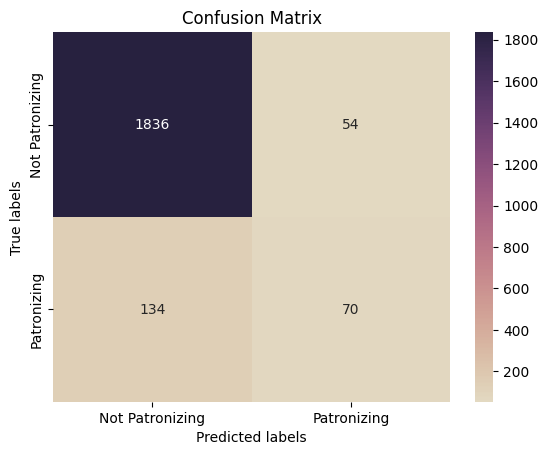

In [ ]:
set(y_pred)
cm = confusion_matrix(y_val, y_pred, labels=[0, 1]) 

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True));  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])
ax.yaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1890
           1       0.56      0.34      0.43       204

    accuracy                           0.91      2094
   macro avg       0.75      0.66      0.69      2094
weighted avg       0.90      0.91      0.90      2094



In [ ]:
# Get one random sample from the test data
random_index = X_val.sample(n=1).index.values[0]

while random_index not in train_data.index:
    random_index = X_val.sample(n=1).index.values[0]

# Extract random sample
tdf = train_data.loc[[random_index]][['text', 'is_patronizing']]
test_paragraph, real_label = tdf['text'].values[0], tdf['is_patronizing'].values[0]

# Get model prediction
predicted_label, raw_outputs = task1_model.predict([tdf['text'].values[0]])
# predicted_label = task1_model.predict(tdf['text'].values[0])

print(f"=== Paragraph example ===\n{test_paragraph.capitalize()}")
print(f"\tReal Label:      {real_label}")
print(f"\tModel Prediction:{predicted_label[0]}")

100%|██████████| 1/1 [00:00<00:00, 163.20it/s]

=== Paragraph example ===
The common thieves then stole a crust of bread , the law came down upon the hungry heads ; the haughty land robber stole land with men resources and all contents . the first they said were a hopeless conviction . while they escaped the law by trick ; that grave , one-sided justice would not do -- the poor call for consideration , too . the cruel people started the unholy war , then from the line of action they kept far ; they pushed to the front sons of the poor , there to do battle , die , suffer galore , as the guns raged , liberty loans they raised , and in glorious tones , we sung freedom 's praise . those who made wars should first went to the front , and of shot and shell bear there the brunt : in first lines of action they were all due , if to their country and people they were true : when this was demanded in right of all , there would have been no more deadly cannon balls : the downtrodden poor people of us joined together and prevented the pakistani 

## Submission Documents

In [ ]:
def get_and_save_predictions(dataset, save_name, model=task1_model):
    y_pred, _ = model.predict(dataset.tolist())
    np.savetxt(f'{save_name}.txt', y_pred, fmt='%d')

# train predictions
get_and_save_predictions(test_data['text'], "test")

# test predictions
get_and_save_predictions(train_data['text'], "dev")

100%|██████████| 105/105 [00:14<00:00,  7.19it/s]
